In [44]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("Plots")
Pkg.add("LinearAlgebra")
Pkg.add("Convex")
import Convex as cvx
import ECOS
using LinearAlgebra, Plots

  Activating project at `C:\Users\leoni\OneDrive\Desktop\Optimal_Control\Lab`
   Resolving package versions...
  No Changes to `C:\Users\leoni\OneDrive\Desktop\Optimal_Control\Lab\Project.toml`
  No Changes to `C:\Users\leoni\OneDrive\Desktop\Optimal_Control\Lab\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\leoni\OneDrive\Desktop\Optimal_Control\Lab\Project.toml`
  No Changes to `C:\Users\leoni\OneDrive\Desktop\Optimal_Control\Lab\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\leoni\OneDrive\Desktop\Optimal_Control\Lab\Project.toml`
  No Changes to `C:\Users\leoni\OneDrive\Desktop\Optimal_Control\Lab\Manifest.toml`


In [116]:
# takes in a 12 vector for the inital state of the robot and the goal state and returns a vector of vectors
# that is N by 12 as the reference trajectory 
function generate_Ref(xic, xg, N, dt, N_mpc, flag)

    # Create our reference as a vector of state vectors
    x_ref = [zeros(12) for i = 1:N+N_mpc]

    if flag == "line"

        # Linearly interpolate between our initial condition and goal
        x_traj = LinRange(xic[4], xg[4], N)
        y_traj = LinRange(xic[5], xg[5], N)

        # Find the constant speed the system needs to move at
        dx = (x_traj[2] - x_traj[1])/dt
        dy = (y_traj[2] - y_traj[1])/dt

        # Set our initial reference to be our initial condition
        x_ref[1] = xic

        # Loop through time and set all variables to make our reference
        for i = 2:N
            # Set all position variables
            x_ref[i][4] = x_traj[i]
            x_ref[i][5] = y_traj[i]
            x_ref[i][6] = xic[6]

            # Set all velocity variables
            x_ref[i][10] = dx
            x_ref[i][11] = dy
        end
    else
        error("Reference flag does not exist")
    end

    # Body should end its trajectory with zero velocity
    x_ref[N][9]  = 0
    x_ref[N][10] = 0
    x_ref[N][11] = 0

    # Pad the end of our reference trajectory
    for i = N+1:N+N_mpc
        x_ref[i] = x_ref[N]
    end

    return x_ref
end

# Takes in the number of time steps we will be simulating, a gait flag that denotes what gait is desired,
# the initial state xic, and the goal state xg
#
# outputs L, an N by 4 vector of vectors where each vector is one of the i values and 1 denotes a foot off
# and 0 denots a foot on the ground
#
# outputs M which is an N by 4 by 3 vector of vectors of vectors that stores the global location of each foot
# in the global coordinate frame
#
# outputs C, the set of all times, i, in which at least one foot is hitting the ground after being in the air
#
# ouptuts Phi, an N by 4 vector where 1 denotes all feet that are going from on the ground to off and 0 to 
# denote a foot that is going off the ground to on
#
# All feet vector have them stacked as 1 - front left, 2 - front right, 3 - back left, 5 - back right
function gait_Scheduler(N, N_mpc, gait_Flag, xg, params, x_ref)
    # Define the number of steps to be taken and initialize all variables
    gaits = 10
    L = [zeros(4) for i = 1:N+N_mpc]
    M = [[zeros(3) for i = 1:4] for i = 1:N+N_mpc]
    Φ = [zeros(4) for i = 1:N+N_mpc]
    
    # Flag 1 is trotting - FR, RL and FL, RR move in sync
    if gait_Flag == 1
        # Start and end with all feet on the ground
        L[1] = zeros(4)
        L[N] = zeros(4)

        # Our robot should be in nominal stance at the beginning and end of the run
        start_COM = x_ref[1][4:6]
        M[1] = [start_COM + [params.foot_Length, -params.hip_Length, -start_COM[3]], 
                start_COM + [params.foot_Length, params.hip_Length, -start_COM[3]], 
                start_COM + [-params.foot_Length, -params.hip_Length, -start_COM[3]], 
                start_COM + [-params.foot_Length, params.hip_Length, -start_COM[3]]]

        final_COM = x_ref[N][4:6]
        M[N] = [final_COM + [params.foot_Length, -params.hip_Length, -start_COM[3]], 
                final_COM + [params.foot_Length, params.hip_Length, -start_COM[3]], 
                final_COM + [-params.foot_Length, -params.hip_Length, -start_COM[3]], 
                final_COM + [-params.foot_Length, params.hip_Length, -start_COM[3]]]
        
        # Find all indices where feet will have a collision with the ground
        steps_Per_Gait = (N-2)/gaits
        steps_Per_Gait_Phase = steps_Per_Gait/2
        
        # Add one to remove the starting pos, add the total number of steps per gait since
        # impact only occurs at the end of a gait, and add one more so that the time of
        # impact is the start of the next gait. This also incorporates the transition to our
        # end state in the same way
        C = [floor(steps_Per_Gait_Phase*i + 1 + 1) for i = 1:(gaits*2)]
        Φ[N] = [0; 1; 1; 0]

        # COM of the robot at the last point of contact
        contact_COM = x_ref[1][4:6]

        # Loop through all indices
        for i = 2:(N-1)
            # Our current gait is the ceil of our time step minus one to remove the 
            # starting state divided by the number of steps per gait
            curr_Gait = ceil((i-1)/steps_Per_Gait)

            # We can tell if we are in the first half of our gait phase or the second through a similar trick
            # Our current time step minus one to remove the start minus our current gait number minus one times the 
            # steps per gait is a quantity that goes from 1 to the number of time steps per gait. Then, we can take
            # the ceiling of this divided b the number of steps per gait phase which will be 1 for the first half of
            # gait and 2 for the second

            # 1 denotes first half of gait, 2 denotes second half of gait
            gait_Phase = ceil((i - 1 - (curr_Gait-1)*steps_Per_Gait)/steps_Per_Gait_Phase)

            # Contact occurs at the beginning of each new gait phase cycle and at the end of our trajectory. These
            # points occur when mod((i-1), steps_Per_Gait)/steps_Per_Gait = 1/steps 
            if i in C
                contact_COM = x_ref[i][4:6]
                if gait_Phase == 1
                    Φ[i] = [1; 0; 0; 1]
                else
                    Φ[i] = [0; 1; 1; 0]
                end 
            end
            
            # If we are in the first half of our gait, our FR and RL legs are on the ground 
            if gait_Phase == 1
                L[i] = [1; 0; 0; 1]
                
                # Define the state of our feet relative to the COM of the robot at the start of each gait, and then
                # add that vector to the COM of the robot when the first foot hit the ground to find the global position
                # of the foot. This distance from the robot's COM for each foot was manually tuned
                M[i] = [[0, 0, 0], 
                        contact_COM + [params.foot_Length*1.75,   params.hip_Length, -contact_COM[3]],
                        contact_COM + [-params.foot_Length, -params.hip_Length, -contact_COM[3]], 
                        [0, 0, 0]]
            # If we are in the second half of our gait, the FL and RR legs are on the ground
            else
                L[i] = [0; 1; 1; 0]
                # Define the state of our feet relative to the COM of the robot at the start of each gait, and then
                # add that vector to the COM of the robot when the first foot hit the ground to find the global position
                # of the foot. This distance from the robot's COM for each foot was manually tuned
                M[i] = [contact_COM + [params.foot_Length*1.75, params.hip_Length, -contact_COM[3]], 
                        [0, 0, 0], 
                        [0, 0, 0], 
                        contact_COM + [-params.foot_Length, -params.hip_Length, -contact_COM[3]]]
            end
        end

        # Pad our variables so that the MPC windows can go past the end of simulation
        for i = N:N+N_mpc
            L[i] = L[N]
            M[i] = M[N]
            Φ[i] = Φ[N]
        end
        
    return L, M, C, Φ
    end
    error("Gait flag does not exist")
end


# Normal RK4
function rk4(params, dynamics, x, dt, u, i, M)
    k1 = dt * dynamics(x, u, i, params, M)
    k2 = dt * dynamics(x + k1/2, u, i, params, M)
    k3 = dt * dynamics(x + k2/2, u, i, params, M)
    k4 = dt * dynamics(x + k3, u, i, params, M)
    x_next = x + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
    return x_next
end

# RK4 that passes x_ref into the dynamics function to make a linear model
function rk4_Linear(params, dynamics, x, dt, u, i, M, x_ref)
    k1 = dt * dynamics(x, u, i, params, M, x_ref)
    k2 = dt * dynamics(x + k1/2, u, i, params, M, x_ref)
    k3 = dt * dynamics(x + k2/2, u, i, params, M, x_ref)
    k4 = dt * dynamics(x + k3, u, i, params, M, x_ref)
    x_next = x + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
    return x_next
end

# Takes in the current state and input to the system, the current time denoted as i, and the locations of the feet
# in the above format. Returns x dot 
function dynamics(x, u, i, params, M)
    # Extract current yaw value and calculate the rotation matrix associated with it and transform the inertia
    # tensor to the body frame
    ψ = x[3]
    R_T = [cos(ψ) sin(ψ) 0; -sin(ψ) cos(ψ) 0; 0 0 1];
    I_hat = (R_T')*params.inertia*R_T

    # Extract the x, y, z position of the com of the body
    x_pos = x[4:6]

    # Define vector from COM of the body to the feet
    r1 = x_pos - M[i][1] 
    r2 = x_pos - M[i][2] 
    r3 = x_pos - M[i][3] 
    r4 = x_pos - M[i][4]

    # Define skew symmetric matricies in order to take the cross product with respect to these r vectors
    r1x = [0 -r1[3] -r1[2]; r1[3] 0 -r1[1]; -r1[2] r1[1] 0]
    r2x = [0 -r2[3] -r2[2]; r2[3] 0 -r2[1]; -r2[2] r2[1] 0]
    r3x = [0 -r3[3] -r3[2]; r3[3] 0 -r3[1]; -r3[2] r3[1] 0]
    r4x = [0 -r4[3] -r4[2]; r4[3] 0 -r4[1]; -r4[2] r4[1] 0]

    # Extract the foot force of each foot
    f1 = u[1:3]
    f2 = u[4:6]
    f3 = u[7:9]
    f4 = u[10:12]

    # Define A and B matrices (kind of, there is also a g vector and the B matrix in this case is stand alone, do not
    # multiply by u)
    m = params.mass
    eye = diagm(ones(3))
    
    A = [zeros(3, 3) zeros(3, 3) R_T zeros(3, 3); zeros(3, 3) zeros(3, 3) zeros(3, 3) diagm(ones(3)); zeros(6, 12)]
    B = [zeros(6, 12); I_hat*r1x I_hat*r2x I_hat*r3x I_hat*r4x; eye/m eye/m eye/m eye/m]
    g = [zeros(11); -9.81]
    
    x_dot = A*x + B*u + g

    # Make all variables close to zero exactly zero to minimize numerical error
    for i = 1:12
        if u[i] <= 1e-6
            u[i] = 0
        end
    end
    
    return x_dot
end

# The same as the dynamics equation above, but it eliminates the rotation of the inertial body so that the
# system is affine
function dynamics_Linear(x, u, i, params, M, x_ref)
    # Extract current yaw value and calculate the rotation matrix associated with it and transform the inertia
    # tensor to the body frame
    ψ = x_ref[3]
    R_T = [cos(ψ) sin(ψ) 0; -sin(ψ) cos(ψ) 0; 0 0 1]
    I_hat = (R_T')*params.inertia*R_T

    # Extract the x, y, z position of the com of the body
    x_pos = x_ref[4:6]

    # Define vector from COM of the body to the feet
    r1 = x_pos - M[i][1] #M[i][1] - x_pos
    r2 = x_pos - M[i][2] #M[i][2] - x_pos
    r3 = x_pos - M[i][3] #M[i][3] - x_pos
    r4 = x_pos - M[i][4] #M[i][4] - x_pos

    # Define skew symmetric matricies in order to take the cross product with respect to these r vectors
    r1x = [0 -r1[3] -r1[2]; r1[3] 0 -r1[1]; -r1[2] r1[1] 0]
    r2x = [0 -r2[3] -r2[2]; r2[3] 0 -r2[1]; -r2[2] r2[1] 0]
    r3x = [0 -r3[3] -r3[2]; r3[3] 0 -r3[1]; -r3[2] r3[1] 0]
    r4x = [0 -r4[3] -r4[2]; r4[3] 0 -r4[1]; -r4[2] r4[1] 0]


    # Define A and B matrices (kind of, there is also a g vector)
    m = params.mass
    eye = diagm(ones(3))
    
    A = [zeros(3, 3) zeros(3, 3) R_T zeros(3, 3); zeros(3, 3) zeros(3, 3) zeros(3, 3) diagm(ones(3)); zeros(6, 12)]
    B = [zeros(3, 3) zeros(3, 3) zeros(3, 3) zeros(3, 3); zeros(3, 3) zeros(3, 3) zeros(3, 3) zeros(3, 3); I_hat*r1x I_hat*r2x I_hat*r3x I_hat*r4x; eye/m eye/m eye/m eye/m]
    g = [zeros(11); -9.81]

    return A*x + B*u + g
end


# Performs the convex, nonlinear MPC for this plant/application and returns the first command to the plant
# params - named tuple with all necessary parameters of the model
# xic - current actaul state of the system
# x_ref - current window of the reference trajectory (vector of vectors)
# N - size of current reference trajectory window
# L - vector of vectors to denote which feet are on/off the ground (see above for more)
# M - vector of vectors with feet location at each time step
# i - current time step of our reference trajectory in the larger simulation
function MPC(params, xic, x_ref, N, L, M, flag_Path)
    # We have 12 states as well as 12 inputs (3 forces on each foot)
    nx = 12
    nu = 12
    
    Q = diagm(ones(nx))
    R = diagm(ones(nu))
    

    # Tune matrices for each path
    if flag_Path == "line"
        # Angles
        Q[1, 1] = 1
        Q[2, 2] = 45
        Q[3, 3] = 1

        # Position
        Q[4, 4] = 1000
        Q[5, 5] = 1
        Q[6, 6] = 1000

        # Angular Velocity
        Q[7, 7] = 1
        Q[8, 8] = 45
        Q[9, 9] = 1

        # Velocity
        Q[10, 10] = 1000
        Q[11, 11] = 1
        Q[12, 12] = 1000

        R = R*2.5
        R[3, 3] = 1
        R[6, 6] = 1
        R[9, 9] = 1
        R[12, 12] = 1
    else
        error("Reference flag does not exist")
    end

    # Create the variables we are solving for
    X = cvx.Variable(nx, N)
    U = cvx.Variable(nu, N-1)

    # First, implement our cost over this window
    obj = 0
    for j = 1:N-1
        x_j = X[:, j]
        u_j = U[:, j]
        x_r = x_ref[j]

        # add stagewise cost
        obj += cvx.quadform(x_r - x_j, Q)
        obj += cvx.quadform(u_j, R)
    end

    # add final cost over this window
    obj += cvx.quadform(x_ref[N] - X[:, N], Q)

    # Create a problem with the objective
    prob = cvx.minimize(obj)

    # Add constraints

    # Must start at the initial condition of the simulation
    prob.constraints += (X[:, 1] == xic)

    for j = 1:N-1
        # Must obey dynamics
        prob.constraints += (X[:, j+1] == rk4_Linear(params, dynamics_Linear, X[:, j], params.dt, U[:, j], j, M, x_ref[j]))

        # Complementary slackness to handle gait constraints
        prob.constraints += (U[1:3, j]*   L[j][1] == 0)
        prob.constraints += (U[4:6, j]*   L[j][2] == 0)
        prob.constraints += (U[7:9, j]*   L[j][3] == 0)
        prob.constraints += (U[10:12, j]* L[j][4] == 0)

        # For each foot, check if it is on the ground. If it is, constrain the z force to be positive and less than some
        # arbitrary max and enforce constraint cones on the x and y forces for each foot

        if (L[j][1] == 0)
            # Z bounds
            prob.constraints += (U[3, j]  >= 0)
            prob.constraints += (U[3, j]  <= params.max_Z)

            # All x and y forces must be within a friction cone
            # Following two blocks are x forces
            prob.constraints += (U[1, j]  >= -params.mu*U[3, j])
            prob.constraints += (U[1, j]  <= params.mu*U[3, j])

            prob.constraints += (U[2, j]  >= -params.mu*U[3, j])
            prob.constraints += (U[2, j]  <= params.mu*U[3, j])
        end

        if (L[j][2] == 0)
            # Z bounds
            prob.constraints += (U[6, j]  >= 0)
            prob.constraints += (U[6, j]  <= params.max_Z)

            # All x and y forces must be within a friction cone
            # Following two blocks are x forces
            prob.constraints += (U[4, j]  >= -params.mu*U[6, j])
            prob.constraints += (U[4, j]  <= params.mu*U[6, j])

            prob.constraints += (U[5, j]  >= -params.mu*U[6, j])
            prob.constraints += (U[5, j]  <= params.mu*U[6, j])
        end

        if (L[j][3] == 0)
            # Z bounds
            prob.constraints += (U[9, j]  >= 0)
            prob.constraints += (U[9, j]  <= params.max_Z)

            # All x and y forces must be within a friction cone
            # Following two blocks are x forces
            prob.constraints += (U[7, j]  >= -params.mu*U[9, j])
            prob.constraints += (U[7, j]  <= params.mu*U[9, j])

            prob.constraints += (U[8, j]  >= -params.mu*U[9, j])
            prob.constraints += (U[8, j]  <= params.mu*U[9, j])
        end

        if (L[j][4] == 0)
            # Z bounds
            prob.constraints += (U[12, j]  >= 0)
            prob.constraints += (U[12, j]  <= params.max_Z)

            # All x and y forces must be within a friction cone
            # Following two blocks are x forces
            prob.constraints += (U[10, j]  >= -params.mu*U[12, j])
            prob.constraints += (U[10, j]  <= params.mu*U[12, j])

            prob.constraints += (U[11, j]  >= -params.mu*U[12, j])
            prob.constraints += (U[11, j]  <= params.mu*U[12, j])
        end
        
    end

    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)
    
    U = U.value
    return U[:, 1]
end

function main()
    # Generates the reference trajectory for the body
    #########################################################
    N = 152
    N_mpc = 20
    xic = zeros(12)
    xg = zeros(12)
    xic[6] = 0.4
    xg[6] = 0.4
    dt = 0.1
    flag_Path = "line"
    flag_Gait = 1

    if flag_Path == "line"     
        xg[4] = 3
    end
 
    # Generate our reference trajectory
    x_ref = generate_Ref(xic, xg, N, dt, N_mpc, flag_Path)
    #########################################################

    # Generates the gait scheduling variables
    #########################################################
    params = (foot_Length = 0.186, inertia = [0.00368 0 0; 0 0.00265 0; 0 0 0.001647], hip_Length = 0.132, mass = 12.454, max_Z = 100, mu = 0.6, dt = dt) 
    L, M, C, Φ = gait_Scheduler(N, N_mpc, flag_Gait, xg, params, x_ref)
    #########################################################

    # Simulate the system on the nonlinear dynamics found above
    #########################################################
    time = LinRange(0, N*dt, N)
    nx = 12
    nu = 12
    X_sim = [zeros(nx) for i = 1:N]
    U_sim = [zeros(nu) for i = 1:N-1]

    # Set the initial condition of the simulation
    X_sim[1] = x_ref[1]
    
    for i = 1:N-1
        # Get the current reference trajectory window and calculate the current input to the system
        x_ref_window = x_ref[i:i+N_mpc]
        L_window = L[i:i+N_mpc]
        M_window = M[i:i+N_mpc]
        u_mpc = MPC(params, X_sim[i], x_ref_window, N_mpc, L_window, M_window, flag_Path)
        U_sim[i] = u_mpc*1

        # Simulate the dynamics of our system
        X_sim[i+1] = rk4(params, dynamics, X_sim[i], dt, u_mpc, i, M)
    end

    return X_sim, U_sim, time
end

X_sim, U_sim, sim_Time = main()

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\leoni\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\leoni\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\leoni\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\leoni\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\leoni\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\leoni\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\leoni\.julia\packages\Convex\b2S4H\src\s

([[0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [2.53908410946481e-14, 5.472716591193065e-5, 1.2918991686613109e-17, 0.00423233817779847, -2.592840186775e-13, 0.425068494266386, 4.60284241277087e-13, 0.0010717055924396959, 2.5837983373226217e-16, 0.0846467635559694, -2.5928401867750002e-12, 0.5013698853277189], [-2.1908423776930848e-9, 0.0002698603234825377, 6.480572733530398e-16, 0.014364648992875574, -6.815636467391207e-13, 0.466800484168629, -4.381784579985532e-8, 0.0031933082734748033, 1.0283480519660895e-14, 0.11799945274553465, -4.222796280616207e-12, 0.3332699127164447], [-9.120285245421242e-9, 0.0006827618683944467, 2.0908311251332066e-15, 0.027470634678942098, -1.3223376427073145e-12, 0.49425993459991924, -9.477105552459925e-8, 0.005006407737846537, 1.612750008772306e-14, 0.14412026097577435, -6.407739959681939e-12, 0.21591909590863773], [-2.167314487874251e-8, 0.0012555526863584341, 4.0830164770099045e-15, 0.04289789987152595, -2.256916130252087e-12, 0.5117778

In [117]:
# The rest of the code in this file handles plotting
N = 152

# x, y, z vector for the com of the body for each time
ang = zeros(3, N)
pos = zeros(3, N)
vel = zeros(3, N)
ang_Vel = zeros(3, N)

# X, Y, and Z force at each foot at each time step
fx = zeros(4, N-1)
fy = zeros(4, N-1)
fz = zeros(4, N-1)

for i = 1:N-1
    ang[:, i] = X_sim[i][1:3]'
    ang_Vel[:, i] = X_sim[i][7:9]'
    pos[:, i] = X_sim[i][4:6]'
    vel[:, i] = X_sim[i][10:12]'
    fx[:, i]  = [U_sim[i][1]; U_sim[i][4]; U_sim[i][7]; U_sim[i][10]]
    fy[:, i]  = [U_sim[i][2]; U_sim[i][5]; U_sim[i][8]; U_sim[i][11]]
    fz[:, i]  = [U_sim[i][3]; U_sim[i][6]; U_sim[i][9]; U_sim[i][12]]
end
pos[:, N] = X_sim[N][4:6]'

1×3 adjoint(::Vector{Float64}) with eltype Float64:
 2.99431  -3.20235e-7  0.392212

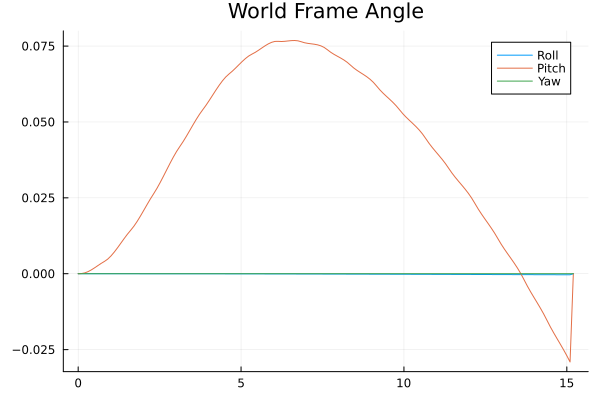

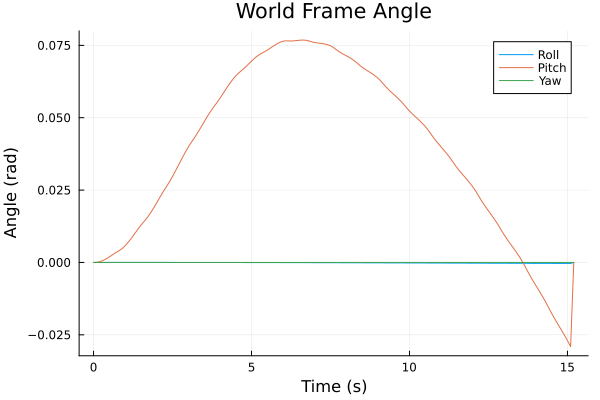

In [118]:
display(plot(sim_Time, ang', title="World Frame Angle", label=["Roll" "Pitch" "Yaw"]))
xlabel!("Time (s)")
ylabel!("Angle (rad)")

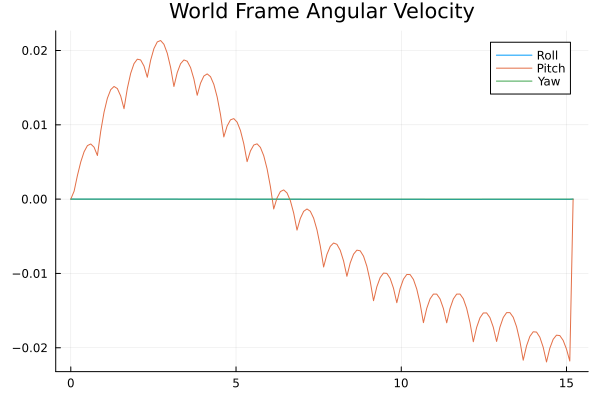

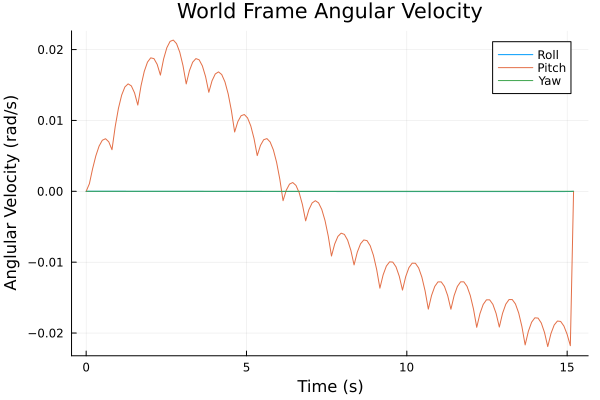

In [119]:
display(plot(sim_Time, ang_Vel', title="World Frame Angular Velocity", label=["Roll" "Pitch" "Yaw"]))
xlabel!("Time (s)")
ylabel!("Anglular Velocity (rad/s)")

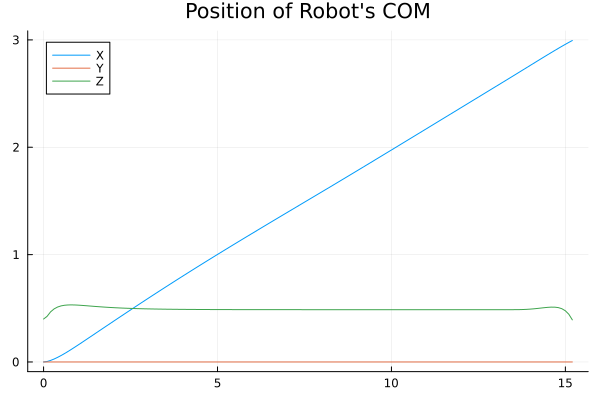

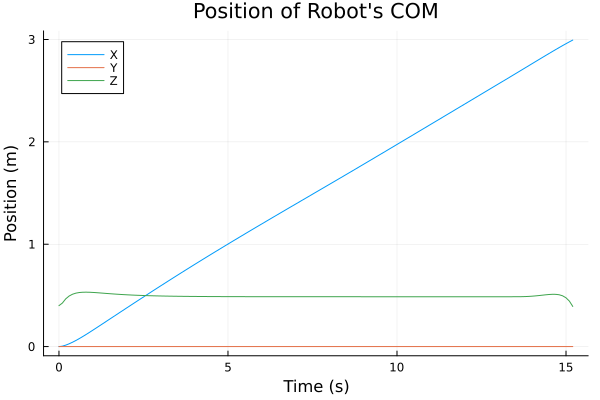

In [120]:
display(plot(sim_Time, pos', title="Position of Robot's COM", label=["X" "Y" "Z"]))
xlabel!("Time (s)")
ylabel!("Position (m)")

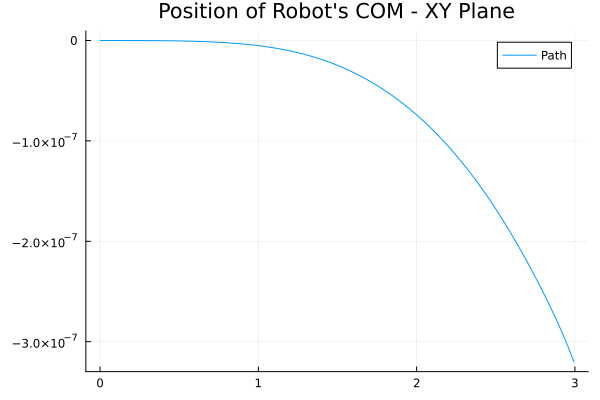

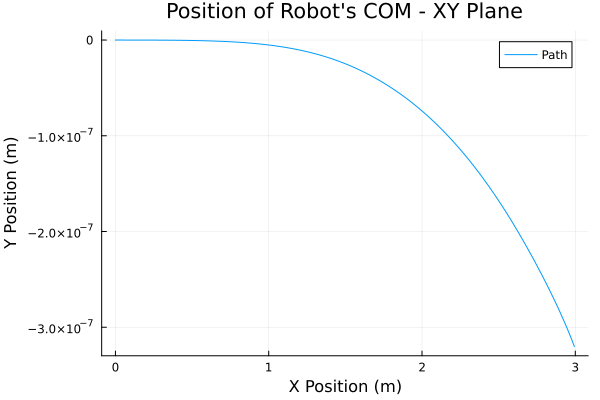

In [121]:
display(plot(pos[1, :], pos[2, :], title="Position of Robot's COM - XY Plane", label="Path"))
xlabel!("X Position (m)")
ylabel!("Y Position (m)")

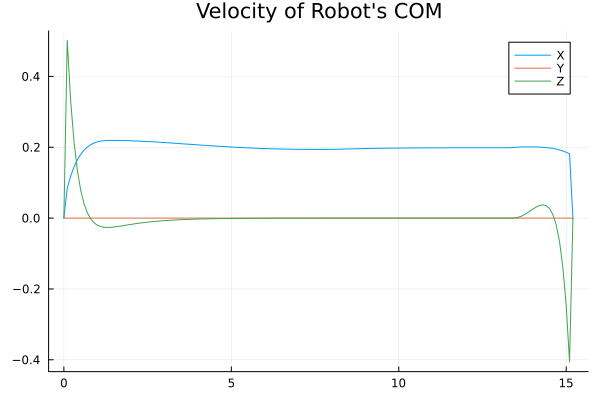

(vel[1, :])' = [0.0 0.0846467635559694 0.11799945274553465 0.14412026097577435 0.16442504287587625 0.18006557259254416 0.19197512050240845 0.20091188037146757 0.20749059349459206 0.2122059068867359 0.21545860324551452 0.21757082970866903 0.2188013763437715 0.21935708240060237 0.2194034868437444 0.21934822949832386 0.2192346142105766 0.21906557217480174 0.21884408636598265 0.21857315990175136 0.2182558049645311 0.2178950298601905 0.21749394552402776 0.2170554290344035 0.21658243869180502 0.21607791436524706 0.21554475577791743 0.2149858139147358 0.21440389436337176 0.21380161437367137 0.2131818964173284 0.21254721608262042 0.2119000973979691 0.21124300538087443 0.2105783251698276 0.2099083553414199 0.20923530570602822 0.2085612932092332 0.20788833907321758 0.20721836622601614 0.20655322028104176 0.20589464703068 0.20524429591589702 0.2046037142285864 0.20397435254512336 0.20335755617119855 0.20275457164803087 0.2021665444366935 0.20159454018074194 0.20103953123745752 0.20050239350461987

1×152 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  0.0846468  0.117999  0.14412  …  0.189664  0.185908  0.181265  0.0

In [122]:
display(plot(sim_Time, vel', title="Velocity of Robot's COM", label=["X" "Y" "Z"]))
xlabel!("Time (s)")
ylabel!("Velocity (m)/s")
@show(vel[1, :]')

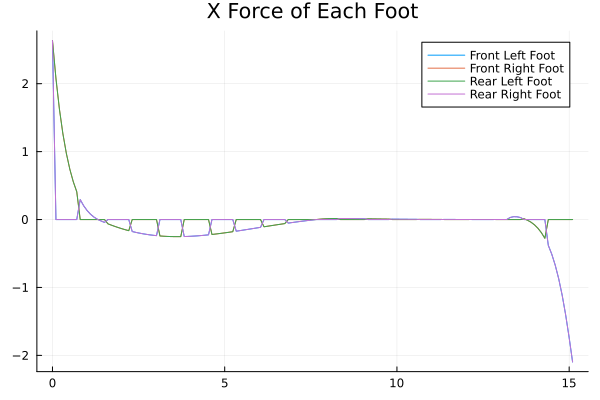

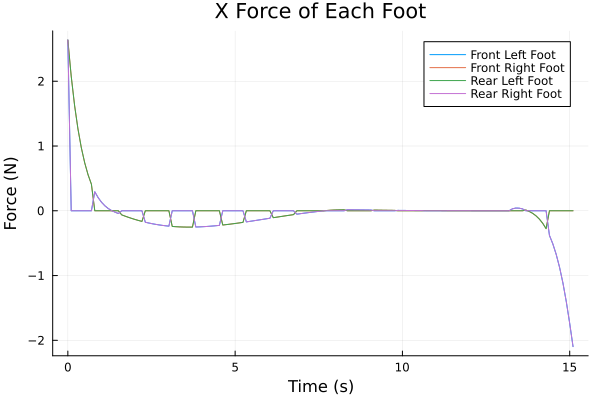

In [123]:
display(plot(sim_Time[1:N-1], fx', title = "X Force of Each Foot", label=["Front Left Foot" "Front Right Foot" "Rear Left Foot" "Rear Right Foot"]))
xlabel!("Time (s)")
ylabel!("Force (N)")

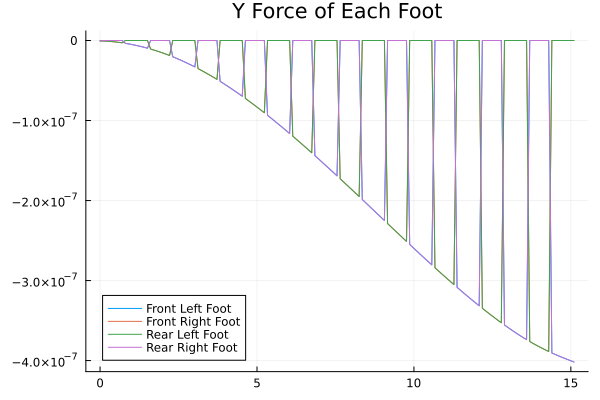

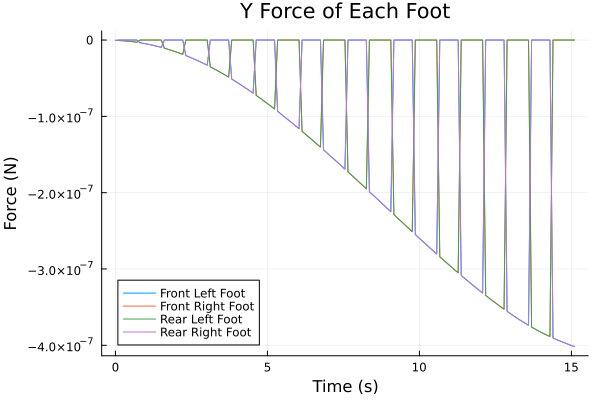

In [124]:
display(plot(sim_Time[1:N-1], fy', title = "Y Force of Each Foot", label=["Front Left Foot" "Front Right Foot" "Rear Left Foot" "Rear Right Foot"]))
xlabel!("Time (s)")
ylabel!("Force (N)")

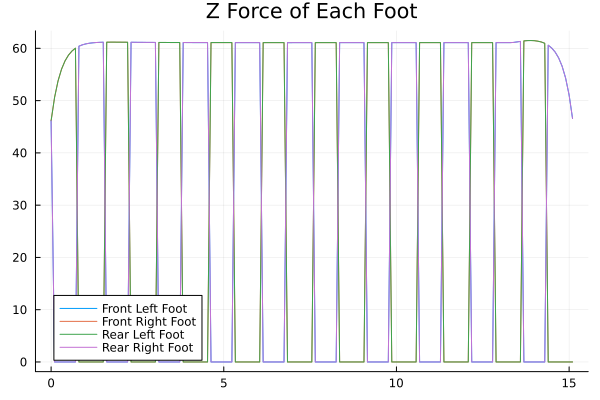

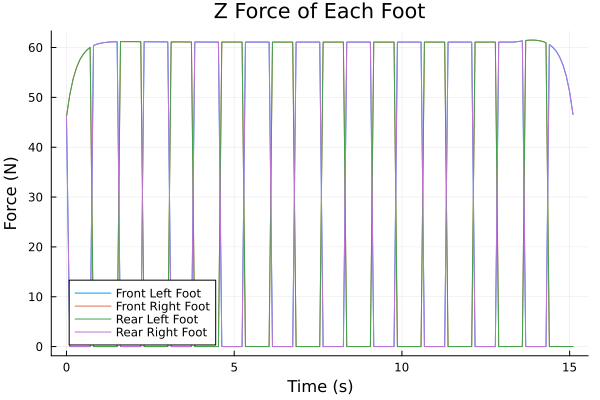

In [125]:
display(plot(sim_Time[1:N-1], fz', title = "Z Force of Each Foot", label=["Front Left Foot" "Front Right Foot" "Rear Left Foot" "Rear Right Foot"], legend=:bottomleft))
xlabel!("Time (s)")
ylabel!("Force (N)")